In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet

from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        eegnet= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
    #     softmax_activation = nn.LogSoftmax(dim=1)
    #     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)


    #     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
    #     classifier.to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        classifier= LSTM_EEGNet_Wrapper(DEVICE, eegnet, input_dim).to(DEVICE)

        model = EEGNet_DF_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
    #     model= EEGNet_Wrapper(DEVICE, df)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


#         train_func= eeg_DF_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-e{EPOCH}.pt"
#                )
#         )

#         pickle.dump( model.return_DF_weights(), 
#                     open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-w-e{EPOCH}.pkl", "wb") 
#                    )    

    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
#     pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-DF_EEG.pkl","wb"))
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


110 4

c0_acc 0.990990990990991 , c1_acc 0.08 , b_acc 0.5354954954954955
115 1

c0_acc 1.0 , c1_acc 0.018867924528301886 , b_acc 0.5094339622641509
123 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5
131 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5
114 0

c0_acc 0.9743589743589743 , c1_acc 0.0 , b_acc 0.48717948717948717
125 4

c0_acc 1.0 , c1_acc 0.08 , b_acc 0.54
112 14

c0_acc 0.896 , c1_acc 0.25 , b_acc 0.573
126 0

c0_acc 1.0 , c1_acc 0.0 , b_acc 0.5
133 1

c0_acc 1.0 , c1_acc 0.01818181818181818 , b_acc 0.509090909090909
129 2

c0_acc 1.0 , c1_acc 0.03389830508474576 , b_acc 0.5169491525423728
116 4

c0_acc 0.9747899159663865 , c1_acc 0.08333333333333333 , b_acc 0.52906162464986
119 19

c0_acc 0.9754098360655737 , c1_acc 0.35185185185185186 , b_acc 0.6636308439587129
118 14

c0_acc 0.959349593495935 , c1_acc 0.25 , b_acc 0.6046747967479675
123 4

c0_acc 0.984 , c1_acc 0.07142857142857142 , b_acc 0.5277142857142857
127 1

c0_acc 1.0 , c1_acc 0.017857142857142856 , b_acc 0.5089285714285714
128 1


     accuracy  f1-score
S01  0.708075  0.613251
S02  0.690476  0.569984
S03  0.698864  0.574985
S04  0.700535  0.577170
S05  0.686747  0.573924
S06  0.737143  0.645610
S07  0.696133  0.658840
S08  0.681081  0.551873
S09  0.712766  0.598513
S10  0.696809  0.582585
S11  0.718563  0.634343
S12  0.784091  0.751153
S13  0.737430  0.689827
S14  0.701657  0.606220
S15  0.699454  0.581201
S16  0.704918  0.588347
S17  0.710843  0.620295
S19  0.684783  0.556662
S20  0.694444  0.569217


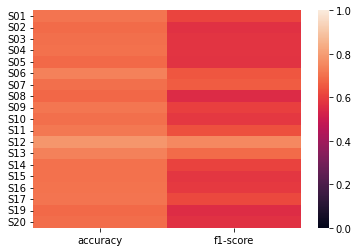

     class0 f1-score  class1 f1-score
S01         0.823970         0.145455
S02         0.815603         0.037037
S03         0.822742         0.000000
S04         0.823899         0.000000
S05         0.814286         0.000000
S06         0.844595         0.148148
S07         0.802867         0.337349
S08         0.810289         0.000000
S09         0.831250         0.035714
S10         0.819048         0.065574
S11         0.831541         0.145455
S12         0.862319         0.500000
S13         0.833922         0.373333
S14         0.820000         0.129032
S15         0.822006         0.035088
S16         0.825806         0.035714
S17         0.826087         0.142857
S19         0.812903         0.000000
S20         0.819672         0.000000


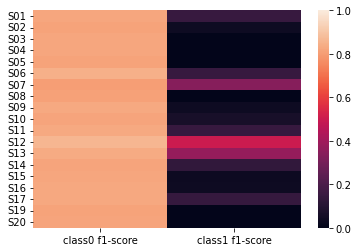

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [11]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [12]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-DF_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

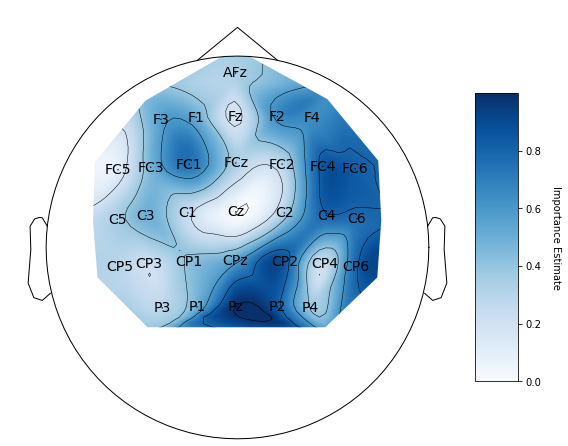

In [14]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)